In [42]:
import matplotlib.pyplot as plt
import numpy as np
import ast
import math
from advisor_client.client import *
client = AdvisorClient()

In [52]:
# get study
study_name = "optimal_jump11"
study = client.get_study_by_name(study_name)
print(study)

Id: 11, name: optimal_jump11, study_configuration: {"randomInitTrials": 20, "params": [{"parameterName": "jump_a", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_b", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_c", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_d", "type": "DOUBLE", "maxValue": 3.5, "minValue": 0}, {"parameterName": "opt_vel", "type": "DOUBLE", "maxValue": 6.0, "minValue": 2.0}], "goal": "MINIMIZE"}, algorithm: BayesianOptimization


Is study done: True
Best epoch: 84
Best trial: Id: 1056, study_name: optimal_jump11, name: BayesianOptimizationTrial, parameter_values: {"opt_vel": 2.573404674614046, "jump_d": 0.74728874364718, "jump_c": 3.0817150033368037, "jump_b": -0.22932039674818583, "jump_a": 1.25645836516762}, objective_value: 11.3409113492


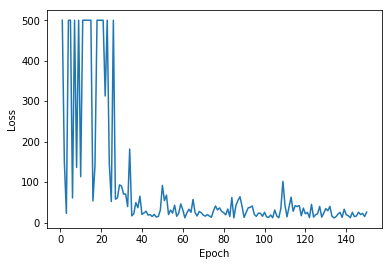

In [53]:
# plot training curve
scale = 500
train_curve = []
train_param = []
trials = client.list_trials(study_name)

for trial in trials:
    trial_metrics = client.list_trial_metrics(study_name,trial.id)
    train_param.append(ast.literal_eval(trial.parameter_values))
    for metrics in trial_metrics:
        train_curve.append(metrics.objective_value)

for param,objval in zip(train_param,train_curve):
    param["objective_value"] = objval

train_curve = np.clip(np.array(train_curve),0,scale)
best_trial = client.get_best_trial(study_name)
best_objval = round(best_trial.objective_value,3)
print("Is study done: %r"%client.is_study_done(study_name))
print("Best epoch: %d"%np.argmin(train_curve))
print("Best trial: {}".format(best_trial))

plt.plot(range(1,len(train_curve)+1),train_curve)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("./records/loss_"+str(best_objval)+"_"+str(scale)+".png")
plt.show()

max objval: 12.776
{'opt_vel': 2.573404674614046, 'objective_value': 11.3409113492, 'jump_d': 0.74728874364718, 'jump_c': 3.0817150033368037, 'jump_b': -0.22932039674818583, 'jump_a': 1.25645836516762}
{'opt_vel': 2.591261489531426, 'objective_value': 11.3420923941, 'jump_d': 0.12831499805155866, 'jump_c': 2.9604842407537504, 'jump_b': 2.148336313505162, 'jump_a': -1.1128071925341643}
{'opt_vel': 2.6079191430165647, 'objective_value': 11.6937703755, 'jump_d': 0.8841530035006895, 'jump_c': 3.2566093051774416, 'jump_b': 2.2613277670394147, 'jump_a': -2.308160043257562}
{'opt_vel': 2.5930922083754018, 'objective_value': 11.7117582817, 'jump_d': 0.9023423168701132, 'jump_c': 3.2365250221727226, 'jump_b': 2.7787083855694057, 'jump_a': -1.6773233459684778}
{'opt_vel': 2.5702183144167647, 'objective_value': 11.7469209756, 'jump_d': 0.7103735702162883, 'jump_c': 3.144905546535149, 'jump_b': -0.25833423667335254, 'jump_a': 1.1111658802709101}
{'opt_vel': 2.6080412633634, 'objective_value': 11.8

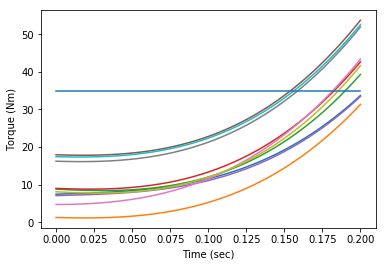

In [54]:
train_curve = np.array(train_curve)
topk_idx = np.argsort(train_curve)[:10]
print("max objval: %.3f"%max(train_curve[topk_idx]))
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
for idx in topk_idx:
    param = train_param[idx]
    print(param)
    a = param["jump_a"]
    b = param["jump_b"]
    c = param["jump_c"]
    d = param["jump_d"]
    y_poly = (10*a * t + 100*b * t ** 2 + 1000*c * t ** 3 + 10*d)
    plt.plot(t,y_poly)
plt.plot(t,y_constant)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
plt.show()

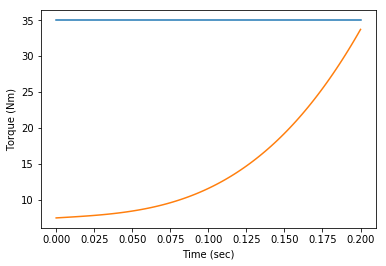

{'opt_vel': 2.573404674614046, 'jump_d': 0.74728874364718, 'jump_c': 3.0817150033368037, 'jump_b': -0.22932039674818583, 'jump_a': 1.25645836516762}


In [55]:
param_dic = ast.literal_eval(best_trial.parameter_values)
a = param_dic["jump_a"]
b = param_dic["jump_b"]
c = param_dic["jump_c"]
d = param_dic["jump_d"]
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
y_poly = (10*a * t + 100*b * t ** 2 + 1000*c * t ** 3 + 10*d)

plt.plot(t,y_constant)
plt.plot(t,y_poly)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
plt.savefig("./records/torque_"+str(best_objval)+".png")
plt.show()
print(param_dic)

In [56]:
# display the best trial
with open("./controllers/my_controller_python/args.txt",'w') as f1:
    f1.write(str(param_dic))

os.system('webots --mode=pause')
with open("./controllers/my_controller_python/metrics.txt",'r') as f2:
    metrics_dic = eval(f2.read())
    y = metrics_dic["jump_metrics"]
print("objective_value:",y)

('objective_value:', 14.793896669112295)


In [59]:
# save dicts to txt
with open("./records/args_"+str(best_objval)+".txt",'wb') as f1:
    f1.write(str(train_param))

In [58]:
# save dicts to csv
import csv
with open("./records/args_"+str(best_objval)+".csv",'wb') as f1:
    # f1.write(str(train_param))
    w = csv.DictWriter(f1,train_param[0].keys())
    w.writeheader()
    for param_dict in train_param:
        w.writerow(param_dict)

In [9]:
# display top 10 trials
top_n = 5
for count,idx in zip(range(top_n),(topk_idx[:top_n])):
    param_dic = train_param[idx]
    with open("./controllers/my_controller_python/args.txt",'w') as f1:
        f1.write(str(param_dic))

    os.system('webots --mode=pause')

    with open("./controllers/my_controller_python/metrics.txt",'r') as f2:
        metrics_dic = eval(f2.read())
        y = metrics_dic["jump_metrics"]
        
    print("top %d, objective_value: %.3f"%count,y)

('objective_value:', 33.33942883001869)
('objective_value:', 25.024363879180832)
('objective_value:', 24.107418207157806)
('objective_value:', 24.10311209813937)
('objective_value:', 26.511422278239746)
('objective_value:', 25.56402447939839)
('objective_value:', 20.298735957994502)
('objective_value:', 42.16631540250994)
('objective_value:', 18.372134552393828)
('objective_value:', 19.768494068120763)


In [57]:
# display top 10 trials
top_n = 5
for count,idx in zip(range(top_n),(topk_idx[:top_n])):
    param_dic = train_param[idx]
    # print(param_dic)
    with open("./controllers/my_controller_python/args.txt",'w') as f1:
        f1.write(str(param_dic))

    os.system('webots --mode=pause')

    with open("./controllers/my_controller_python/metrics.txt",'r') as f2:
        metrics_dic = eval(f2.read())
        y = metrics_dic["jump_metrics"]
        
    print("top %d, objective_value: %.3f"%(count,y))

top 0, objective_value: 14.794
top 1, objective_value: 270.693
top 2, objective_value: 19.278
top 3, objective_value: 23.019
top 4, objective_value: 17.870
